In [1]:
# I am not sure I entirely understand the given methods. So in Verma and Lewis method
# we go through every single row and see how a bit flip would affect it.
# But we do not multiply the quadratic coefficients by 2. 
# In examples the quadratic coefficients are always twice smaller in a 
# QUBO row as there will be another instance of the same coefficient, just in a different row.
# So 6x1x6 will be a 3 in row 1 and a 3 in row 6, but when they are added together, they will make a 6.

# TODO check if verma and lewis penalty is doing everything as expected

In [2]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import neal
import greedy
import tabu
import matplotlib.pyplot as plt

import sys
from pathlib import Path
current_path = Path().resolve()
sys.path.append(str(current_path / '../Data/Multidimensional Knapsack'))
from util import *

from IPython.display import display_html
from itertools import chain, cycle

import time
import pickle

# Load data

In [31]:
data_folder = '../data/Multidimensional Knapsack/'
# Weish dataset has smallers problebls, WEING has larger problems.
# We have Weish[01-30] files in Weish folder. Load them.
weish_files_no = 30
weish_file_paths = ['weish//Weish'+ str(i).zfill(2) +'.npz' for i in range(1, weish_files_no + 1)]
weish_loaded_files = [np.load(data_folder + i) for i in weish_file_paths]
# We have WEING[1-8] files in Weing folder. Load them.
weing_files_no = 8
weing_file_paths = ['weing//WEING'+ str(i) +'.npz' for i in range(1, weing_files_no + 1)]
weing_loaded_files = [np.load(data_folder + i) for i in weing_file_paths]
# Merge the datasets and get the needed information.
loaded_files = weish_loaded_files + weing_loaded_files
qubo_sizes = [i['n'] for i in loaded_files]
objectives = [i['objective'] for i in loaded_files]
constraints = [i['constraint'] for i in loaded_files]

# Custom Methods

In [32]:
def convert_1d_qubo_to_2d(qubo, n):
    if (len(qubo)!= (n) * ((n+1) * 0.5)   + 1):
        print('check that n is the correct size')
        return None, None
    constant = qubo[0]
    linear_terms = np.array(qubo[1:(n + 1)])
    no_of_quadratic_terms = len(qubo) - len(linear_terms) -1
    quadratic_terms = np.array(qubo[-no_of_quadratic_terms:])
    k = 0
    qubo_coeffs = []
    for i in range(n):
        coeffs = []
        for j in range(n):
            if(i == j):
                coeffs.append(linear_terms[i])
            elif(j>i):
                coeffs.append(quadratic_terms[k])
                k+=1
            else:
                coeffs.append(0)
        qubo_coeffs.append(coeffs)
    qubo_coeffs = np.array(qubo_coeffs)

    return qubo_coeffs, constant

In [33]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align:left">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [34]:
# TODO add penalty function choosing
def data_prep(qubo_sizes, objectives, constraints, minimization=False):
    # If we are solving maximization problem, we will need to convert it to 
    # minimization by multiplying the objective function by -1
    coef = 1 if minimization else -1
    # Get the unconstrained objective function and the constraint function with constants
    obj_qubos, obj_constants, con_qubos, con_constants = [], [], [], []
    for i in range(len(qubo_sizes)):
        # Unconstrained objective function
        obj = convert_1d_qubo_to_2d(objectives[i], qubo_sizes[i])
        obj_qubos.append(obj[0])
        obj_constants.append(obj[1])
        # Constraint function
        const = convert_1d_qubo_to_2d(constraints[i], qubo_sizes[i])
        con_qubos.append(const[0])
        con_constants.append(const[1])
    # Calculate penalties
    penalties = [util.verma_penalty(i) for i in obj_qubos]
    # QUBO matrix (no constraints)
    Qs = [coef*obj_qubo + penalty * con_qubo for obj_qubo, penalty, con_qubo in zip(obj_qubos, penalties, con_qubos)]
    # Change QUBO matrix to the dwave format
    Qs = [util.convert_QUBO_to_dwave_format(Q) for Q in Qs]
    # Constants
    #cs = [obj_constant+ penalty * con_constant for obj_constant, penalty, con_constant in zip(obj_constants, penalties, con_constants)]
    return Qs, penalties, obj_qubos, obj_constants, con_qubos, con_constants

In [35]:
def run_sampler(Qs, sampler, repeats, **kwargs):
    # Format {seed : [objective_energies, constraint_energies]}
    runs = {}
    # Solve every QUBO n times with a different seed to simulate different runs.
    # Start with 1 as simulated annealing breaks with 0.
    for seed in range(1, repeats + 1):
        clear_output(wait=True)
        # Solve every QUBO
        objs, cons = [], []
        for problem_num in range(len(Qs)):
            response =  sampler.sample_qubo(Qs[problem_num], seed = seed, **kwargs)
            
            # If we want to see more details
            # print("samples=" + str(list(response.samples())))
            # print("energies=" + str(list(response.data_vectors['energy'])) )
            
            # TODO choose best solution, not just first
            solution = list(response.samples())[-1]
            y = np.array([int(solution[i]) for i in range(len(solution))])
            
            # Even though we have multiplied the objective function by -1 to 
            # transfer it to minimization problem when defining a QUBO,
            # we do not need to multiply it by -1 again as we are using the original 
            # unmultipled objective function here.
            # So here we will have the original objective function value
            obj = y.transpose().dot(obj_qubos[problem_num]).dot(y) + obj_constants[problem_num]
            # The constraint function before multiplying it by penalty coefficient
            con = y.transpose().dot(con_qubos[problem_num]).dot(y) + con_constants[problem_num]
            
            objs.append(obj)
            cons.append(con)

        runs[seed] = (objs, cons)
        print(np.round(seed/repeats * 100, 2), '%')
        
    return runs

In [36]:
def record_results(runs, qubo_sizes, penalties, repeats, minimization=False): 
    coef = 1 if minimization else -1
    results = []
    # 1: QUBO size, 2: calculated penalty coefficient, 3: objective function energy 
    # 4: number of broken constraints,
    # 5: total QUBO energy (if transfering maximisation problem to minimisation,
    # we need to take the negative).
    # Total energy should be negative if no constraints were broken.
    for i in range(1, repeats + 1):
        energies = [coef*obj+con*penalty for obj, con, penalty in zip(runs[i][0], runs[i][1], penalties)]
        results.append(pd.DataFrame({'Size' : qubo_sizes, 
                                     'Penalty' : penalties, 
                                     'Objective Function' : runs[i][0], 
                                     'Broken Constraints' : runs[i][1],
                                     'Energy (minimisation)' : energies}))
    return results

In [61]:
# Show total energies of all tries in all problems in a single df
def energy_table(results):
    energies = pd.DataFrame()
    repeats = len(results) # Number of repeats is equivalent to the number of results
    for i in range(repeats):
        energies[f'Energy (minimisation) {i}'] = results[i]['Energy (minimisation)']
    return energies

In [ ]:
# Make a table that will display which solution were feasible
def feasibility_table(results):
    feasiblity = pd.DataFrame()
    repeats = len(results) # Number of repeats is equivalent to the number of results
    # Solution is feasibly if no constraints were broken
    for i in range(repeats):
        feasiblity[f'Feasible {i}'] = results[i]['Broken Constraints'] == 0
    return feasiblity

In [70]:
def feasibility_statistic(results):
    # Make tables with energies and feasible results
    feasibility = feasibility_table(results)
    energies = energy_table(results)
    # The number of results corresponds to the number of repeats
    repeats = len(results)
    
    # Calculate number of feasible solutions (in all runs)
    stats = pd.DataFrame({'Feasible' : feasibility.sum(axis=1)})
    # Calculate feasibility rate
    stats['Feasibility rate'] = stats['Feasible'] / repeats
    # Calculate mean energy
    stats['Energy mean'] = energies.mean(axis=1)
    # Calculate energy standard deviation
    stats['Energy SD'] = energies.std(axis=1)
    # Calculate total row
    stats.loc['Total'] = stats.sum()
    # Calculate mean row
    stats.loc['Mean'] = stats.mean()
    # Calculate SD row
    stats.loc['SD'] = stats.std()
    
    return stats

# Prepare data

In [37]:
QUBOs, penalties, obj_qubos, obj_constants, con_qubos, con_constants = data_prep(qubo_sizes, objectives, constraints)
repeats = 10

## Greedy

In [38]:
greedy_sampler = greedy.SteepestDescentSampler()
greedy_runs = run_sampler(QUBOs, greedy_sampler, repeats, num_reads=100)

100.0 %


## Simulated Annealing

In [39]:
# Less reads to compensate the run time
sa_sampler = neal.SimulatedAnnealingSampler()
sa_runs = run_sampler(QUBOs, sa_sampler, repeats, num_reads=10)

100.0 %


## Tabu

In [40]:
tabu_sampler = tabu.TabuSampler()
tabu_runs = run_sampler(QUBOs, tabu_sampler, repeats, timeout=20)

100.0 %


## Record the results

In [42]:
greedy_results = record_results(greedy_runs, qubo_sizes, penalties, repeats)
sa_results = record_results(sa_runs, qubo_sizes, penalties, repeats)
tabu_results = record_results(tabu_runs, qubo_sizes, penalties, repeats)
    
# Display the first repetition table
rep = 0
display_side_by_side(greedy_results[rep], sa_results[rep], tabu_results[rep], titles=['Greedy', 'SA', 'Tabu'])

,Size,Penalty,Objective Function,Broken Constraints,Energy (minimisation)
0,85,892,3495,23656,21097657
1,85,892,2651,19254,17171917
2,90,892,2144,173897,155113980
3,85,892,2152,19195,17119788
4,90,892,5193,104325,93052707
5,100,892,4451,18146,16181781
6,100,892,2310,25464,22711578
7,100,892,2638,39176,34942354
8,100,892,1996,31643,28223560
9,110,892,4080,84708,75555456


## Analyse results

In [63]:
# Show total energies of all tries in all problems in a single df
energies_greedy = energy_table(greedy_results)
energies_sa = energy_table(sa_results)
energies_tabu = energy_table(tabu_results)

energies_greedy

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,21097657,20647904,21509266,22496393,37239905,16717096,16143337,35770983,22320914,22767483
1,17171917,41423334,31718581,21241478,29080999,14342947,23310996,16657037,18653618,15639988
2,155113980,40474614,50656096,45666429,42973671,18188648,43738485,25659242,23693768,54104453
3,17119788,14434019,22198424,10091694,27299333,13334479,11768612,25876094,15339001,16177076
4,93052707,19289671,37279951,57803135,52219980,22958277,62205852,24447155,16482642,20553076
5,16181781,41114014,18748200,16952878,24877104,27740955,24006088,21047094,32470048,30844274
6,22711578,78099955,30849217,35838702,18628834,23624129,74121860,28883859,22938845,22820478
7,34942354,73556998,21469248,23808480,19423193,29371061,58300492,64187219,45218394,23524700
8,28223560,35763710,17502912,26470603,28715859,32918426,27190719,36095217,22656181,29183785
9,75555456,127180377,99608714,81678061,113814897,104117768,88721495,79929109,63102527,79808070


In [64]:
# Show feasible solutions
feasible_full_greedy = feasibility_table(greedy_results)
feasible_full_sa = feasibility_table(sa_results)
feasible_full_tabu = feasibility_table(tabu_results)

feasible_full_tabu

,Feasible 0,Feasible 1,Feasible 2,Feasible 3,Feasible 4,Feasible 5,Feasible 6,Feasible 7,Feasible 8,Feasible 9
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False


In [71]:
# Calculate number of feasible solutions with mean and SD (in all runs)
feasible_greedy = feasibility_statistic(greedy_results)
feasible_sa = feasibility_statistic(sa_results)
feasible_tabu = feasibility_statistic(tabu_results)

# Display the table
display_side_by_side(feasible_greedy, feasible_sa, feasible_tabu, titles=['Greedy', 'SA', 'Tabu'])

,Feasible,Feasibility rate,Energy mean,Energy SD
0,0.0,0.0,2.367109e+07,7.149206e+06
1,0.0,0.0,2.292409e+07,8.677865e+06
2,0.0,0.0,5.002694e+07,3.881689e+07
3,0.0,0.0,1.736385e+07,5.860640e+06
4,0.0,0.0,4.062924e+07,2.509955e+07
5,0.0,0.0,2.539824e+07,7.844149e+06
6,0.0,0.0,3.585175e+07,2.180330e+07
7,0.0,0.0,3.938021e+07,1.974375e+07
8,0.0,0.0,2.847210e+07,5.690859e+06
9,0.0,0.0,9.135165e+07,1.952550e+07


# Run Length Distribution

## Greedy

In [16]:
#run solver
sampler = greedy.SteepestDescentSampler()

# Solve QUBO a lot of times
problem_num = 25
seed = 0
response =  sampler.sample_qubo(newQs[problem_num], seed = seed, num_reads=100000)

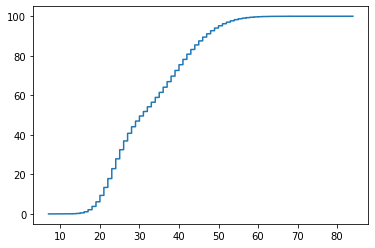

In [17]:
x = []
y = []

for steps, energy in response.data(fields=['num_steps', 'energy'], sorted_by='num_steps'):
    x.append(steps)
    y.append(energy)

# Sort both lists by x
x, y = (list(t) for t in zip(*sorted(zip(x, y))))
    
# Our target is the mean energy that Verma and Lewis penalty produces
target = (sum(y)/len(y))

cumulative_y = [i < target for i in y]
cumulative_y_percentage = (np.cumsum(cumulative_y)/sum(cumulative_y))*100

plt.plot(x, cumulative_y_percentage)

## Tabu

In [99]:
#run solver
sampler = tabu.TabuSampler()

x = []
y = []

# Hyperparameters
timeout = 10 # default 20
problem_num = 25
# num restarts has to be 1 (Towards a Characterisation of the Behaviour of Stochastic Local Search Algorithms for SAT)
for seed in range(1, 1000):
    start = time.time()
    response =  sampler.sample_qubo(newQs[problem_num], seed = seed, timeout=timeout, num_reads=1, num_restarts=1)
    end = time.time()
    x.append(end - start)
    data = response.data(fields=['energy'])
    energy = next(data).energy
    y.append(energy)
    

In [100]:
# Sort both lists by x
x, y = (list(t) for t in zip(*sorted(zip(x, y))))

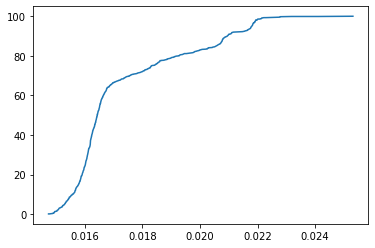

In [101]:
# Our target is the mean energy that Verma and Lewis penalty produces
target = (sum(y)/len(y))

cumulative_y = [i < target for i in y]
cumulative_y_percentage = (np.cumsum(cumulative_y)/sum(cumulative_y))*100

plt.plot(x, cumulative_y_percentage)

# Save results

In [ ]:
# TODO proper saving

In [41]:
data_folder = '../Data/Produced/'

In [42]:
# TODO add other algorithms

In [46]:
energies_sa.to_pickle(data_folder + 'sa_energies_new.pkl')

In [43]:
with open(data_folder + 'sa_energies_new.p', 'wb') as f:
    pickle.dump(energies_sa, f)

# Statistical significance

In [64]:
new_energies_sa = energies_sa

In [56]:
old_energies_sa = energies_sa

In [73]:
new_energies_sa

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,-902.131051,-2141.590319,-836.791027,-1068.257379,-1763.874852,-1475.377804,-2112.100354,-1874.971665,-1281.590319,-2218.397875
1,4730.862069,6060.804598,10192.367816,12637.517241,11076.678161,20567.862069,8396.643678,6560.149425,6507.333333,1848.620690
2,-3217.507014,-2810.909419,-2584.046493,-2754.056112,-988.062926,-2875.351102,-2457.103407,-1848.045691,-2413.351904,-2306.849699
3,-1130.404022,-777.937843,-1236.188300,-1358.720293,-641.279707,-738.703839,-1378.826325,-930.756856,-673.583181,206.925046
4,-2409.998012,-3166.764215,-2964.873161,-1693.217893,-3317.784891,-2295.336382,-2389.109344,-2490.290258,-2623.191650,-2377.018688
5,-3295.432277,-3832.820749,-2412.000000,-3020.600000,-3442.288184,-2752.375793,-1849.429395,-3060.842075,-3336.577522,-3288.933141
6,-2111.843068,-2157.328024,-3109.797050,-860.437758,-2794.000000,-2546.764602,-2600.558112,-3585.919764,-3072.844838,-1968.474926
7,-2943.143953,-3766.274336,-3971.374631,-3570.353982,-3190.282596,-1675.234218,-2947.894985,-3378.329204,-3094.434218,-2687.184071
8,-2907.792325,-3346.986907,-2091.544470,-2853.242889,-3289.448758,-2376.260045,-3725.064560,-2736.237923,980.685327,-2590.589165
9,-3038.496804,-3362.469406,-3165.136986,6979.304110,3475.221005,21242.445662,-3942.113242,-3099.084932,-3322.638356,-3168.582648


In [72]:
old_energies_sa

,Energy (minimisation) 0,Energy (minimisation) 1,Energy (minimisation) 2,Energy (minimisation) 3,Energy (minimisation) 4,Energy (minimisation) 5,Energy (minimisation) 6,Energy (minimisation) 7,Energy (minimisation) 8,Energy (minimisation) 9
0,1064359,930121,1282321,1342006,1745001,1872304,401959,1513352,748674,1228315
1,809123,636792,670356,1078623,550992,613876,934243,2071094,771698,979706
2,777682,814551,1157031,834678,1450204,536447,1649108,1695865,1298578,1459087
3,1269897,2492120,1262772,1655733,1025376,1642915,884698,835206,1614714,1366486
4,1201929,967255,2780615,1811292,1851426,1295248,989566,988282,1712814,1254057
5,1610191,1322709,805087,1236329,1448591,596297,1251753,1156860,736642,1006118
6,1697585,1223121,1780338,965930,861754,1215579,665063,1191297,1122931,599638
7,1052120,1175272,947556,891776,667456,1108824,899728,1240618,855547,1200478
8,2044134,1259946,1285652,786684,1168741,1191944,1949622,1748498,1156574,1081028
9,1010243,1992693,1535954,1428919,1372386,1351293,1565095,1721470,1564152,1339040


In [65]:
import scipy.stats as stats

In [69]:
new_energies_sa.iloc[0]

Energy (minimisation) 0    -902.131051
Energy (minimisation) 1   -2141.590319
Energy (minimisation) 2    -836.791027
Energy (minimisation) 3   -1068.257379
Energy (minimisation) 4   -1763.874852
Energy (minimisation) 5   -1475.377804
Energy (minimisation) 6   -2112.100354
Energy (minimisation) 7   -1874.971665
Energy (minimisation) 8   -1281.590319
Energy (minimisation) 9   -2218.397875
Name: 0, dtype: float64

In [71]:
old_energies_sa.iloc[0]

Energy (minimisation) 0    1064359
Energy (minimisation) 1     930121
Energy (minimisation) 2    1282321
Energy (minimisation) 3    1342006
Energy (minimisation) 4    1745001
Energy (minimisation) 5    1872304
Energy (minimisation) 6     401959
Energy (minimisation) 7    1513352
Energy (minimisation) 8     748674
Energy (minimisation) 9    1228315
Name: 0, dtype: int64

In [70]:
stats.ttest_ind(new_energies_sa.iloc[0], old_energies_sa.iloc[0])

Ttest_indResult(statistic=-8.575018150805937, pvalue=8.994725044770677e-08)

# new

In [153]:
def verma_penalty(qubo_obj):
        weights = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        k = 0
        for i in range(len(qubo_obj)):
            weights[k]= qubo_obj[i][i]
            weights[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights[k]+= qubo_obj[i][j]
                    else:
                        weights[k+1]-=qubo_obj[i][j]
            k = k+2
        return min(weights)

In [32]:
def new_penalty(qubo_obj, con_obj):
        weights_obj = np.zeros(shape = (len(qubo_obj) * 2), dtype='int64')
        k = 0
        
        for i in range(len(qubo_obj)):
            weights_obj[k]= qubo_obj[i][i]
            weights_obj[k+1]= -qubo_obj[i][i]
            for j in range(len(qubo_obj)):
                if(i!=j):
                    if(qubo_obj[i][j] > 0):
                        weights_obj[k]+= qubo_obj[i][j]
                    else:
                        weights_obj[k+1]-=qubo_obj[i][j]
            k = k+2
            
        weights_con = np.zeros(shape = (len(con_obj) * 2), dtype='int64')
        k = 0
        
        for i in range(len(con_obj)):
            weights_con[k]= con_obj[i][i]
            weights_con[k+1]= -con_obj[i][i]
            for j in range(len(con_obj)):
                if(i!=j):
                    if(con_obj[i][j] > 0):
                        weights_con[k]+= con_obj[i][j]
                    else:
                        weights_con[k+1]-=con_obj[i][j]
            k = k+2
        
        return max(weights_obj)/min(weights_con[weights_con > 0])

In [160]:
con_qubos

[array([[127183,  19348,  17556, ...,   -752,   -376,   -188],
        [     0, 272396,  39720, ...,   -688,   -344,   -172],
        [     0,      0, 324856, ...,   -640,   -320,   -160],
        ...,
        [     0,      0,      0, ...,  -3376,     16,      8],
        [     0,      0,      0, ...,      0,  -1692,      4],
        [     0,      0,      0, ...,      0,      0,   -847]]),
 array([[ 58723,  19348,  17556, ...,   -752,   -376,   -188],
        [     0, 181676,  39720, ...,   -688,   -344,   -172],
        [     0,      0, 261096, ...,   -640,   -320,   -160],
        ...,
        [     0,      0,      0, ...,  -1216,     16,      8],
        [     0,      0,      0, ...,      0,   -612,      4],
        [     0,      0,      0, ...,      0,      0,   -307]]),
 array([[402487,  19348,  17556, ...,   -752,   -376,   -188],
        [     0, 798124,  39720, ...,   -688,   -344,   -172],
        [     0,      0, 864264, ...,   -640,   -320,   -160],
        ...,
        [   

In [162]:
new_penalties = [new_penalty(i, j) for i, j in zip(obj_qubos, con_qubos)]
new_penalties

[1.053128689492326,
 10.25287356321839,
 0.35751503006012025,
 1.6307129798903108,
 0.3546719681908549,
 0.514121037463977,
 0.5262536873156343,
 0.5262536873156343,
 0.40270880361173816,
 0.8146118721461187,
 0.6487272727272727,
 0.8146118721461187,
 0.8146118721461187,
 2.258227848101266,
 1.0682634730538922,
 0.6888030888030888,
 0.27269948028125957,
 0.29429231276806334,
 0.25261965448881335,
 6.96875,
 6.96875,
 0.3157522123893805,
 0.31959871013973484,
 0.40712003651300777,
 0.23529411764705882,
 0.40712003651300777,
 0.40712003651300777,
 0.40712003651300777,
 0.40712003651300777,
 1.1276864728192162,
 36.36363636363637,
 29.41738299904489,
 21.28541810642709,
 36.36363636363637,
 36.36363636363637,
 33.36944745395449,
 48.92743039707896,
 14.907523293005145]

In [163]:
penalties

[892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 892,
 30800,
 30800,
 30800,
 30800,
 30800,
 30800,
 107200,
 107200]

In [129]:
new_penalties

[-0.004949396306818182,
 -0.0009306557158119658,
 -0.0008879650866462793,
 -0.0018300288865546219,
 -0.0008367855427473583,
 -0.0010875078027465668,
 -0.0010875078027465668,
 -0.0010875078027465668,
 -0.0009458129750271444,
 -0.00045750722163865546,
 -0.0006481352306547619,
 -0.00045750722163865546,
 -0.00045750722163865546,
 -0.0002636482294188862,
 -0.0003593621080858086,
 -0.0005791846742021277,
 -0.00026428815230582523,
 -0.00020467428336466166,
 -0.0002243930319422978,
 -0.00023416498655913978,
 -0.00023416498655913978,
 -0.00017147514763779528,
 -0.0001670041698619632,
 -0.00011437680540966387,
 -0.00024732928733674046,
 -0.00011437680540966387,
 -0.00011437680540966387,
 -0.00011437680540966387,
 -0.00011437680540966387,
 -6.591205735472155e-05,
 -0.1708984375,
 -0.3612987987987988,
 -0.17641129032258066,
 -0.1708984375,
 -0.1708984375,
 -0.30078125,
 -0.013745732668067227,
 -0.025397258612324114]